In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = '14'

In [2]:
#Load the complete df_train
with open('./data/df_trend_season_lags.bin', 'rb') as f:
    df_train = pickle.load(f)

In [3]:
df_train.head()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,
1957-09-04,12.6,3,0,0,0,0,0,0,0,1,0,0,0,13.691262,-1.091262,-1.391185,-0.491109,0.708967,12.585588
1957-09-05,16.4,4,0,0,0,0,0,0,0,1,0,0,0,13.691338,2.708662,-1.091262,-1.391185,-0.491109,12.954146
1957-09-06,15.8,5,0,0,0,0,0,0,0,1,0,0,0,13.691414,2.108586,2.708662,-1.091262,-1.391185,16.279885
1957-09-07,20.6,6,0,0,0,0,0,0,0,1,0,0,0,13.691491,6.908509,2.108586,2.708662,-1.091262,14.979969
1957-09-08,14.2,7,0,0,0,0,0,0,0,1,0,0,0,13.691567,0.508433,6.908509,2.108586,2.708662,19.743151


In [4]:
df_train.shape

(23403, 19)

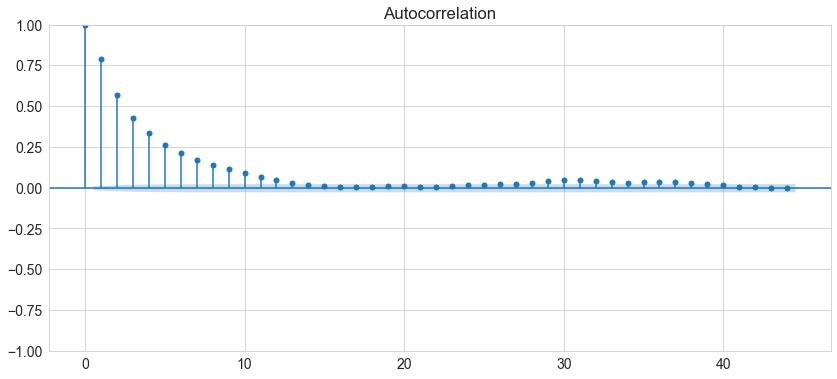

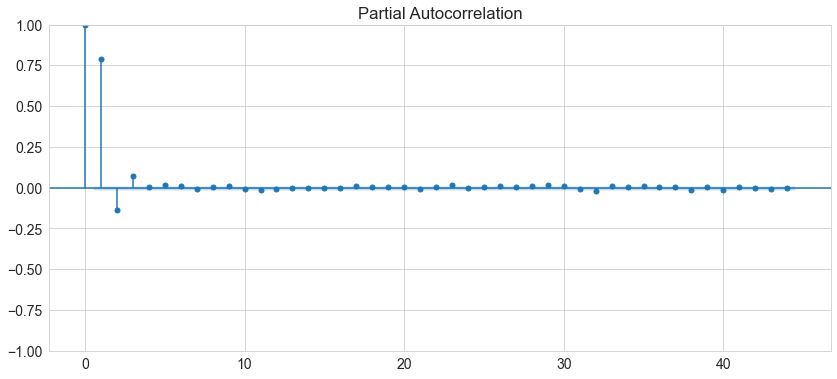

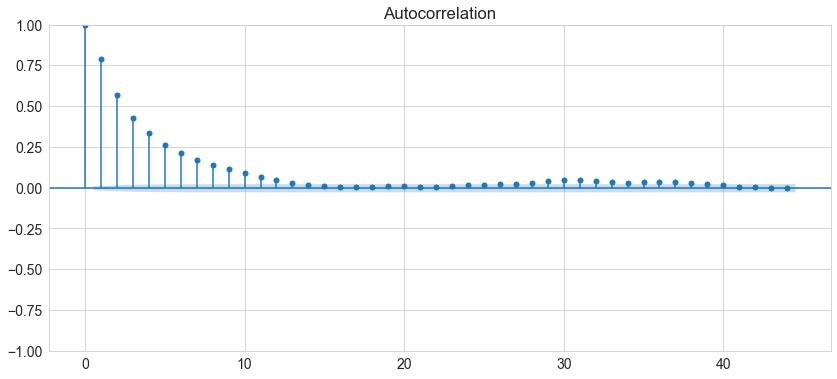

In [5]:
plot_pacf(df_train['remainder'])
plot_acf(df_train['remainder'])

**Observation:**
* ACF-Plot is showing an exponential and slow decay
* PACF-Plot shows a drop after the second certain lag
* Best model should be an AR-Model

### 2. Comparing AR and ARIMA models

In [6]:
# Train an AR model on the 'remainder' column
ar_model = AutoReg(endog= df_train['remainder'], lags = 1).fit()

In [7]:
# Create a copy of df_train
df_train_ar_arima = df_train.copy()

In [8]:
df_train_ar_arima['ar_prediction'] = ar_model.predict()

In [9]:
# Training the ARIMA model on the 'remainder' column
arima = ARIMA(endog= df_train['remainder'], order = (1,0,3)).fit()

In [10]:
df_train_ar_arima['arima_prediction'] = arima.predict()

In [11]:
df_train_ar_arima.dropna(inplace=True)

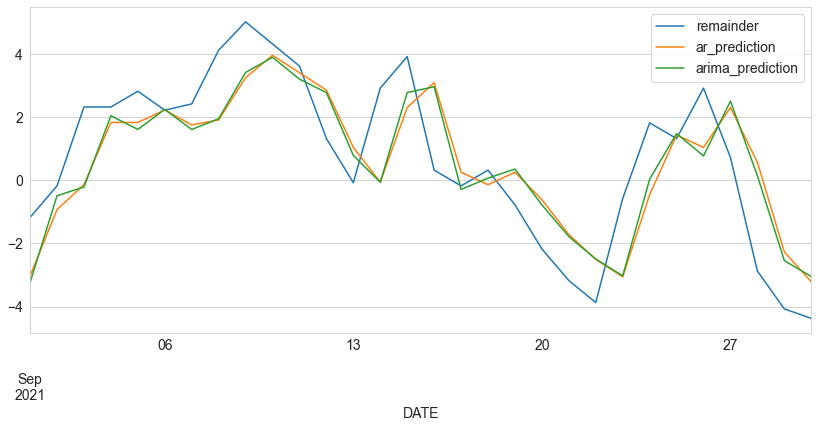

In [12]:
# Plot all relevant data
df_train_ar_arima[['remainder', 'ar_prediction', 'arima_prediction']].iloc[-30:,:].plot();

**Observation:**
* The AR model seems to replicate the remainder slightly better than the ARIMA model

In [13]:
ar_error = round(mean_absolute_error(df_train_ar_arima['remainder'], df_train_ar_arima['ar_prediction']),2)
arima_error = round(mean_absolute_error(df_train_ar_arima['remainder'], df_train_ar_arima['arima_prediction']),2)

In [14]:
f'Mean absolute error for Auto Regression: {ar_error} and it was improved to {arima_error} with ARIMA'

'Mean absolute error for Auto Regression: 1.82 and it was improved to 1.8 with ARIMA'

In [15]:
df_train_ar_arima['full_pred_arima'] = df_train_ar_arima['trend_seasonal']+ df_train_ar_arima['arima_prediction']

In [16]:
df_train_ar_arima['full_pred_ar'] = df_train_ar_arima['trend_seasonal'] + df_train_ar_arima['ar_prediction']

In [17]:
base_model_error = round(mean_absolute_error(df_train_ar_arima['TG'], df_train_ar_arima['trend_seasonal']), 3)
ar_error = round(mean_absolute_error(df_train_ar_arima['TG'], df_train_ar_arima['full_pred_ar']), 3)
arima_error = round(mean_absolute_error(df_train_ar_arima['TG'], df_train_ar_arima['full_pred_arima']), 3)

In [18]:
f'Mean absolute error for the base model {base_model_error}, the  Auto Regression: {ar_error} and  ARIMA {arima_error}'

'Mean absolute error for the base model 3.021, the  Auto Regression: 1.821 and  ARIMA 1.796'